<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_5_DualGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
#@title IMPORTS 
#@markdown run to import modules
import argparse
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

In [138]:
#@title HYPERPARAMETERS 
dataset_name = "maps" #@param ["facades", "cityscapes", "maps"]
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = { "facades" : { "url" : 'https://www.dropbox.com/s/0gnznt9m480rps7/facades.zip?dl=1',
                          "train_mode" : "train",
                          "test_mode" : "test"},
            "cityscapes" : { "url" : "https://www.dropbox.com/s/2a4v13fd45zwdg8/cityscapes.zip?dl=1",
                            "train_mode" : "train",
                            "test_mode" : "val"},
            "maps" : { "url" : "https://www.dropbox.com/s/ut7g1r73cq5zdrn/maps.zip?dl=1",
                      "train_mode" : "train",
                      "test_mode" : "val"}
            }

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    batch_size=8,    
    dataset_name=dataset_name,
    dataset_url=datasets[dataset_name]["url"],
    dataset_train_mode=datasets[dataset_name]["train_mode"],
    dataset_test_mode=datasets[dataset_name]["test_mode"],    
    lr=.0002,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    lambda_adv = 1,
    lambda_cycle = 10,
    lambda_gp = 10)

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed images/maps


In [139]:
#@title DOWNLOAD DATASET
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/ut7g1r73cq5zdrn/maps.zip?dl=1


In [140]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS

import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [141]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

In [142]:
#@title CONFIGURE DATALOADERS
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

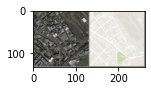

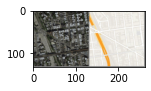

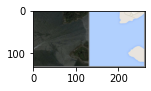

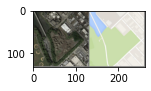

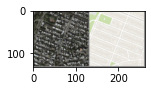

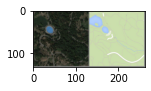

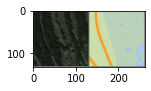

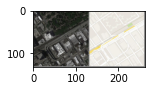

In [143]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 2 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
images = dataiter.next()

for i in range(len(images["A"])):
  imshow(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

In [144]:
#@title GENERATOR & DISCRIMINATOR
from torchvision.models import vgg19

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size, affine=True))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_size, affine=True),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.down1 = UNetDown(channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5, normalize=False)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 256)
        self.up5 = UNetUp(512, 128)
        self.up6 = UNetUp(256, 64)

        self.final = nn.Sequential(nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1), nn.Tanh())

    def forward(self, x):
        # Propogate noise through fc layer and reshape to img shape
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        u1 = self.up1(d7, d6)
        u2 = self.up2(u1, d5)
        u3 = self.up3(u2, d4)
        u4 = self.up4(u3, d3)
        u5 = self.up5(u4, d2)
        u6 = self.up6(u5, d1)

        return self.final(u6)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discrimintor_block(in_features, out_features, normalize=True):
            """Discriminator block"""
            layers = [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discrimintor_block(in_channels, 64, normalize=False),
            *discrimintor_block(64, 128),
            *discrimintor_block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, kernel_size=4)
        )

    def forward(self, img):
        return self.model(img)

In [145]:
#@title SETUP, LOSS and INITIALIZE MODELS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss function
cycle_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
G_AB = Generator()
G_BA = Generator()
D_A = Discriminator()
D_B = Discriminator()

if cuda:
  G_AB.cuda()
  G_BA.cuda()
  D_A.cuda()
  D_B.cuda()
  cycle_loss.cuda()

# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Using CUDA


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [146]:
#@title COMPUTING GRADIENT PENALTY WGAN GP
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    validity = D(interpolates)
    fake = Variable(FloatTensor(np.ones(validity.shape)), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=validity,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [147]:
#@title SAMPLING IMAGES
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs["A"].type(FloatTensor))
    fake_B = G_AB(real_A)
    AB = torch.cat((real_A.data, fake_B.data), -2)
    real_B = Variable(imgs["B"].type(FloatTensor))
    fake_A = G_BA(real_B)
    BA = torch.cat((real_B.data, fake_A.data), -2)
    img_sample = torch.cat((AB, BA), 0)
    path = "images/%s/%s.png" % (hp.dataset_name, batches_done)
    save_image(img_sample, path, nrow=8, normalize=True)
    return path
    

In [148]:
#@title OPTIMIZERS
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

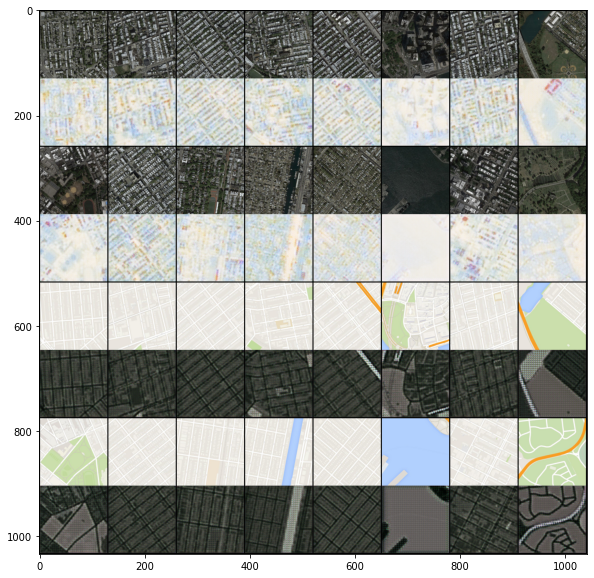

[Epoch 6/200] [Batch 55/137] [D loss: -0.149340] [G loss: 0.016556, cycle: 0.177501] ETA: 1:57:31.145125

In [ ]:
#@title TRAINING
batches_done = 0
prev_time = time.time()
for epoch in range(hp.n_epochs):
  for i, batch in enumerate(dataloader):

    # Configure input
    imgs_A = Variable(batch["A"].type(FloatTensor))
    imgs_B = Variable(batch["B"].type(FloatTensor))

    # ----------------------
    #  Train Discriminators
    # ----------------------

    optimizer_D_A.zero_grad()
    optimizer_D_B.zero_grad()

    # Generate a batch of images
    fake_A = G_BA(imgs_B).detach()
    fake_B = G_AB(imgs_A).detach()

    # ----------
    # Domain A
    # ----------

    # Compute gradient penalty for improved wasserstein training
    gp_A = compute_gradient_penalty(D_A, imgs_A.data, fake_A.data)
    # Adversarial loss
    D_A_loss = -torch.mean(D_A(imgs_A)) + torch.mean(D_A(fake_A)) + hp.lambda_gp * gp_A

    # ----------
    # Domain B
    # ----------

    # Compute gradient penalty for improved wasserstein training
    gp_B = compute_gradient_penalty(D_B, imgs_B.data, fake_B.data)
    # Adversarial loss
    D_B_loss = -torch.mean(D_B(imgs_B)) + torch.mean(D_B(fake_B)) + hp.lambda_gp * gp_B

    # Total loss
    D_loss = D_A_loss + D_B_loss

    D_loss.backward()
    optimizer_D_A.step()
    optimizer_D_B.step()

    if i % hp.n_critic == 0:

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Translate images to opposite domain
        fake_A = G_BA(imgs_B)
        fake_B = G_AB(imgs_A)

        # Reconstruct images
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)

        # Adversarial loss
        G_adv = -torch.mean(D_A(fake_A)) - torch.mean(D_B(fake_B))
        # Cycle loss
        G_cycle = cycle_loss(recov_A, imgs_A) + cycle_loss(recov_B, imgs_B)
        # Total loss
        G_loss = hp.lambda_adv * G_adv + hp.lambda_cycle * G_cycle

        G_loss.backward()
        optimizer_G.step()

        # --------------
        # Log Progress
        # --------------

        # Determine approximate time left
        batches_left = hp.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time) / hp.n_critic)
        prev_time = time.time()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                hp.n_epochs,
                i,
                len(dataloader),
                D_loss.item(),
                G_adv.data.item(),
                G_cycle.item(),
                time_left,
            )
        )

    # Check sample interval => save sample if there
    if batches_done % hp.sample_interval == 0:
        clear_output()
        visualise_output(sample_images(batches_done), 10, 10)

    batches_done += 1
 